# Super learner example with scikit-stack 

The intention of this notebook is to provide a working example of the *scikit-stack* library so that if you need to use it for your personal project you have a starting point. We are applying the algorithm with a set of models over a synthetic dataset generated using `make_classification()` function from sklearn

In [1]:
from skstack.stacker import Stacker
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Ivan Valles Perez\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Generate a data set for the experiment

In the lines below we generate a data set with 1000 samples and 20 variables. We flip the target value of the 50% of the instances in order to make the data more noisy. Finally, we split the data set in train and test using a random 70-30 division.

In [2]:
np.random.seed(655321)

data, target = make_classification(n_samples=1000, n_informative=15, flip_y=0.5)
data_train, data_test, target_train, target_test = train_test_split(data, target)

In [9]:
data.shape

(1000, 20)

## Generate the metapredictors using a bunch of models

Below we select a bunch of models (5) in order to stack them and combine the predictions using a meta-model (model trained over the predictions of other models). We use a k-folds loop of 10 folds.

In [3]:
models = [("ExtraTrees_basic", ExtraTreesClassifier()),
          ("RandomForest_basic", RandomForestClassifier()),
          ("KNN_1", KNeighborsClassifier(1)),
          ("SVC_0.9", SVC(C=0.9, probability=True)),
          ("NB_basic", GaussianNB())]

Instantiate the stacker class

In [4]:
stk = Stacker(train_X=data_train, train_y=target_train, train_id=list(range(len(target_train))), folds=10)

Run a loop for generating the train and test metapredictors. The test metapredictor is generated by a model trained with the whole training set.

In [5]:
train_metapredictors=[]
test_metapredictors=[]
aucs=[]
for model_name, model in models:
    metapred_train = stk.generate_training_metapredictor(model)
    metapred_test = stk.generate_test_metapredictor(test_X=data_test, test_id=list(range(data_test.shape[0])))
    auc_train = roc_auc_score(y_true=target_train, y_score=metapred_train)
    auc_test = roc_auc_score(y_true=target_test, y_score=metapred_test)
    train_metapredictors.append((model_name, metapred_train))
    test_metapredictors.append((model_name, metapred_test))
    aucs.append(auc_test)
    print(f"Model {model_name} trained. CV_AUC={auc_train}, TEST_AUC={auc_test}")

Model ExtraTrees_basic trained. CV_AUC=0.6321572587814436, TEST_AUC=0.6895330112721417
Model RandomForest_basic trained. CV_AUC=0.6536992653386342, TEST_AUC=0.7135909822866344
Model KNN_1 trained. CV_AUC=0.6054022146519782, TEST_AUC=0.6074074074074074
Model SVC_0.9 trained. CV_AUC=0.712841994466926, TEST_AUC=0.7318196457326892
Model NB_basic trained. CV_AUC=0.6808312412434483, TEST_AUC=0.7250885668276973


## Build the meta-model

Build the stacked dataset to use for training the meta-model. This dataset has the same order as the target vector

In [6]:
metanames_tr, metapredictors_tr = zip(*train_metapredictors)
metanames_te, metapredictors_te = zip(*test_metapredictors)
df_stack_train = pd.concat(metapredictors_tr, axis=1)
df_stack_train.columns = metanames_tr
df_stack_test = pd.concat(metapredictors_te, axis=1)
df_stack_test.columns = metanames_te

In [10]:
df_stack_train.head()

,ExtraTrees_basic,RandomForest_basic,KNN_1,SVC_0.9,NB_basic
0,0.9,0.4,1.0,0.711097,0.646982
1,0.2,0.5,0.0,0.357074,0.329605
2,0.6,1.0,1.0,0.710278,0.796832
3,0.6,0.4,1.0,0.542526,0.536658
4,0.7,0.7,1.0,0.728490,0.775009


It is always a good idea to apply PCA before the meta-model to get rid of the correlations between metapredictors

In [7]:
metalearner = Pipeline([("pca", PCA()), ("clf", SVC(C=0.9, probability=True))])
metalearner = metalearner.fit(df_stack_train.values, target_train)
final_prediction = metalearner.predict_proba(df_stack_test.values)[:,1]
auc_metamodel = roc_auc_score(y_true=target_test, y_score=final_prediction)

## Performance comparison

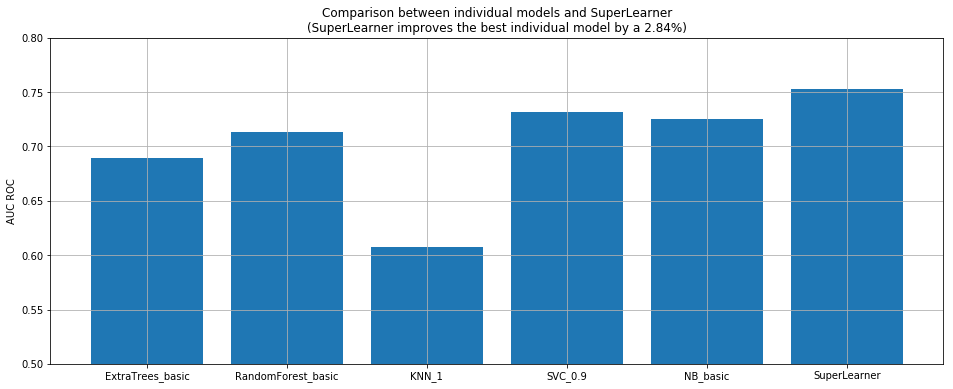

In [11]:
plt.figure(figsize=[16, 6])
plt.ylim([0.5, 0.8])
plt.grid()
ax = plt.gca()
plt.bar(list(range(len(aucs)+1)), aucs + [auc_metamodel])
ratio = np.round(100*auc_metamodel/max(aucs)-100, decimals=2)
ax.set_xticklabels(["labels"] + list(list(zip(*models))[0])+["SuperLearner"])
plt.title(f"Comparison between individual models and SuperLearner\n(SuperLearner improves the best individual model by a {ratio}%)")
plt.ylabel("AUC ROC")
plt.show()

## Conclusions and next steps

- The meta-learner (SuperLearner in the figure above) improves the best individual model (SVM) by a ~3%. This is an unfair case because the meta-learner usually works better when combining much more models (~150-1000).
- The intuitive principle of the super-learner is that, in the worse case, it will perform as good as the best of your individual models; considering that you have a big enough training set and that your test set is not biased
- Same models with different parameters must be stacked in order to get the most of each algorithm
- Different metalearners must be tested in order to assure the best solution